## exercises 01

## Exploratory Weather Data Analysis 

Exploratory analysis of weather data

In [19]:
### Import dependencies 
import pandas as pd # Adding dataframe functionality
from matplotlib import pyplot as plt # Add plotting functionality
from statistics import mean
import folium, json
import pandas as pd

In [20]:
### Read in the weather data from a .csv-file 
weather_data = pd.read_csv("../Data/Raw/weather/weather.csv", sep=",")


In [21]:
### Print the dimensions of the data as well as all the fields 
print(f"Length of the data: {len(weather_data)}")
print(f"Fields: {len(weather_data.columns)}")
for i in weather_data.columns:
    print(i)

Length of the data: 20220
Fields: 9
date
iso3166-2
RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed


In [22]:
### Check for missing values in the data set 
weather_data.isnull().values.any()

False

In [23]:
### Add two new columns based on the iso3166-2 column to 
### create a "country"-column and a "region"-column
weather_data[["country","region"]]= weather_data["iso3166-2"].str.split("-",expand=True)


In [24]:
### Filter the data based on the country
nl_data = weather_data[weather_data["country"] == "NL"]

In [25]:
### Group data based on region and for each region calculate 
### min, max, mean and median for each numeric column. 
### For each of the regions, write these to a file named after the region
agg_data = nl_data.groupby("region")
for i in agg_data:
    # print(i[0])
    # print(i[1])
    with open(f"{i[0]}_summary.txt","w") as outfile:
        outfile.write(str(i[1].describe()))

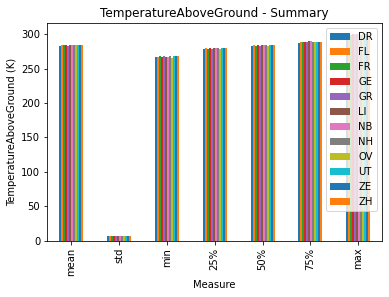

In [26]:
### Plot TemperatureAboveGround 
tmp_df = pd.DataFrame()
for i in agg_data:
    
    tmp = i[1].describe()
    tmp_df[i[0]] = tmp["TemperatureAboveGround"][1:]
tmp_df.plot(kind="bar")
plt.title("TemperatureAboveGround - Summary")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Measure")
plt.show()

In [27]:
### Group data based on date and calculate means of all 
### numerical columns 
agg_data = nl_data.groupby("date")
mean_data = {}
index = []
for i in agg_data:
    index.append(i[0])
    tmp = i[1].describe()
    for j in tmp:
        if j in mean_data.keys():
            mean_data[j].append(tmp[j]["mean"])
        else:
            mean_data[j] = [tmp[j]["mean"]]
new_data = pd.DataFrame(mean_data,index=index)
new_data.index = pd.to_datetime(new_data.index)

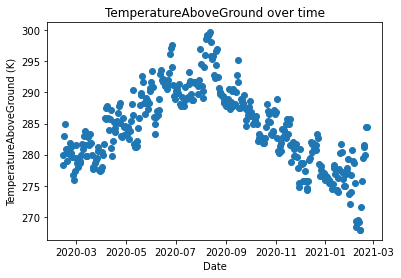

In [28]:
### Plot TemperatureAboveGround v. time 
plt.plot_date(new_data.index, new_data["TemperatureAboveGround"],xdate=True)
plt.title("TemperatureAboveGround over time")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Date")
plt.show()
# print(new_data)

## exercises 02

### GETTING USED TO PLOT GEOJSON

In [29]:
nl_coronadata = "../data/raw/corona/nl_corona.csv"
nl_metadata = "../data/raw/metadata/nl_metadata.json"
nl_geojson = "../data/raw/shapefiles/nl.geojson"

corona_df = pd.read_csv(nl_coronadata, sep = "\t")

with open(nl_metadata, "r") as f:
    country_metadata = json.load(f)

with open(nl_geojson, "r") as f:
    geojson = json.load(f)

In [30]:
m = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")
m

### GEODATA WRANGLING

In [35]:
region_map = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

corona_df["region"] = corona_df["region_code"].map(region_map)

corona_df_by_region = corona_df.groupby(by = "region_name")["hospitalized_addition"].sum().reset_index()

population_map = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}

corona_df_by_region["population"] = corona_df_by_region["region_name"].map(population_map)

l = [i for i in corona_df_by_region["region_name"] if i not in region_map.keys()]
corona_df["region_name"]=corona_df['region_name'].str.replace("Noord-Holland", "North Holland")
corona_df["region_name"]=corona_df['region_name'].str.replace("Noord-Brabant", "North Brabant")
corona_df["region_name"]=corona_df['region_name'].str.replace("Zuid-Holland", "South Holland")

corona_df_by_region["region_code"] = corona_df_by_region["region_name"].map(region_map)

cases_per_population = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: corona_df_by_region["hospitalized_addition"][i]/corona_df_by_region["population"][i] for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["cases_per_population"] = corona_df_by_region["region_name"].map(cases_per_population)

corona_df_by_region

,region_name,hospitalized_addition,population,region_code,cases_per_population
0,Drenthe,363.0,493657,NL-DR,0.000735
1,Flevoland,519.0,422979,NL-FL,0.001227
2,Friesland,349.0,649944,NL-FR,0.000537
3,Gelderland,2510.0,2086142,NL-GE,0.001203
4,Groningen,279.0,586061,NL-GR,0.000476
5,Limburg,2191.0,1117164,NL-LI,0.001961
6,North Brabant,4207.0,2563432,NL-NB,0.001641
7,North Holland,3662.0,2879611,NL-NH,0.001272
8,Overijssel,1125.0,1162500,NL-OV,0.000968
9,South Holland,6037.0,3708585,NL-ZH,0.001189


### GEODATA VISUALISATION

In [36]:
m_cases = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases",
    data = corona_df_by_region,
    columns = ["region_code", "hospitalized_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "Hospitalized",
).add_to(m_cases)

folium.LayerControl().add_to(m_cases)

m_cases

In [37]:
m_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "population",
    data = corona_df_by_region,
    columns = ["region_code", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_population)

m_population

In [38]:
m_cases_per_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases per population",
    data = corona_df_by_region,
    columns = ["region_code", "cases_per_population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_cases_per_population)

m_cases_per_population